# Building a data analyst agent with LangGraph and Azure Container Apps dynamic sessions



**NOTE**: Building LLM systems that interact with SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your agent's needs. This will mitigate though not eliminate the risks of building a model-driven system. For more on general security best practices, see our [security guidelines](https://python.langchain.com/v0.2/docs/security/).

## Setup

Let's get set up by installing our Python dependencies and setting our OpenAI credentials, Azure Container Apps sessions pool endpoint, and our SQL database connection string.

### Install dependencies

In [1]:
#%pip install -qU langgraph langchain-azure-dynamic-sessions langchain-openai langchain-community pandas matplotlib

### Set credentials

By default this demo uses:
- Azure OpenAI for the model: https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource

- Azure Container Apps dynamic sessions for code execution: https://learn.microsoft.com/en-us/azure/container-apps/sessions-code-interpreter?

This LangGraph architecture can also be used with any other [tool-calling LLM](https://python.langchain.com/v0.2/docs/how_to/tool_calling) and any SQL database.

In [2]:
from dotenv import load_dotenv, find_dotenv
import os
import ast
import base64
import io
import json
import operator
from functools import partial
from typing import Annotated, List, Literal, Optional, Sequence, TypedDict

import pandas as pd
from IPython.display import display
from langchain_azure_dynamic_sessions import SessionsPythonREPLTool
from langchain_community.utilities import SQLDatabase
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from matplotlib.pyplot import imshow
from langsmith import traceable
from datetime import datetime, date
from PIL import Image

In [3]:


# Load environment variables from .env file
load_dotenv()

# Access the environment variables
AZURE_OPENAI_API_KEY = os.getenv('AZURE_OPENAI_API_KEY')
AZURE_OPENAI_ENDPOINT = os.getenv('AZURE_OPENAI_API_ENDPOINT')
AZURE_OPENAI_DEPLOYMENT_NAME = os.getenv('AZURE_OPENAI_DEPLOYMENT_NAME')
SESSIONS_POOL_MANAGEMENT_ENDPOINT = os.getenv('SESSIONS_POOL_MANAGEMENT_ENDPOINT')
AZURE_OPENAI_API_VERSION = os.getenv('AZURE_OPENAI_VERSION')
SQL_SERVER = os.getenv('SQL_SERVER')
SQL_USER=os.getenv('SQL_USER')
SQL_PWD=os.getenv('SQL_PWD')
SQL_DATABASE = os.getenv('SQL_DATABASE')
LANGCHAIN_TRACING_V2 = os.getenv('LANGCHAIN_TRACING_V2')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
LANGCHAIN_ENDPOINT = os.getenv('LANGCHAIN_ENDPOINT')
LANGCHAIN_PROJECT = os.getenv('LANGCHAIN_PROJECT')
print(f"AZURE_OPENAI_ENDPOINT: {AZURE_OPENAI_ENDPOINT}")
print(f"SESSIONS_POOL_MANAGEMENT_ENDPOINT: {SESSIONS_POOL_MANAGEMENT_ENDPOINT}")

AZURE_OPENAI_ENDPOINT: https://gpt4-assistants-api.openai.azure.com/
SESSIONS_POOL_MANAGEMENT_ENDPOINT: https://eastus.dynamicsessions.io/subscriptions/20fb8150-494e-4483-bd14-745ca60fafa9/resourceGroups/Default-ActivityLogAlerts/sessionPools/aca-dyn-session-arash


In [4]:
# import logging
 
# logging.basicConfig(level=logging.DEBUG)
# logger = logging.getLogger(__name__)

## Testing the ROAPI endpoint



In [5]:
import requests

# Replace with your actual roapi URL
url = "http://roapi-app-arash.dhbjd9bvccbjedea.eastus.azurecontainer.io:8000/api/schema"

response = requests.get(url)

if response.status_code == 200:
    schema = response.json()
    print(schema)
else:
    print("Error:", response.status_code)

{'asl': {'fields': [{'name': 'Id', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'AccountId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'AccountType', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'DeviceId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'DeviceType', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'ApiName', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'LoggedTime', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'ProfileId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'TenantId', 'data_type': 'Utf8', 

For our LLM we need to make sure that we use a model that supports [tool-calling](https://python.langchain.com/v0.2/docs/how_to/tool_calling).

In [6]:
llm = AzureChatOpenAI(azure_endpoint=AZURE_OPENAI_ENDPOINT, api_key=AZURE_OPENAI_API_KEY,
    deployment_name=AZURE_OPENAI_DEPLOYMENT_NAME, openai_api_version=AZURE_OPENAI_API_VERSION)


And the [dynamic sessions tool](https://python.langchain.com/v0.2/docs/integrations/tools/azure_container_apps_dynamic_sessions/) is what we'll use for code execution.

In [7]:
repl = SessionsPythonREPLTool(
    pool_management_endpoint=SESSIONS_POOL_MANAGEMENT_ENDPOINT
)

## Define graph

Now we're ready to define our application logic. The core elements are the [agent State, Nodes, and Edges](https://langchain-ai.github.io/langgraph/concepts/#core-design).

### Define State
We'll use a simple agent State which is just a list of messages that every Node can append to:

In [8]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

Since our code interpreter can return results like base64-encoded images which we don't want to pass back to the model, we'll create a custom Tool message that allows us to track raw Tool outputs without sending them back to the model.

In [9]:
class RawToolMessage(ToolMessage):
    """
    Customized Tool message that lets us pass around the raw tool outputs (along with string contents for passing back to the model).
    """

    raw: dict
    """Arbitrary (non-string) tool outputs. Won't be sent to model."""
    tool_name: str
    """Name of tool that generated output."""

### Define Nodes

First we'll define a node for calling our model. We need to make sure to bind our tools to the model so that it knows to call them. We'll also specify in our prompt the schema of the SQL tables the model has access to, so that it can write relevant SQL queries.

We'll use our models tool-calling abilities to reliably generate our SQL queries and Python code. To do this we need to define schemas for our tools that the model can use for structuring its tool calls.

Note that the class names, docstrings, and attribute typing and descriptions are crucial here, as they're actually passed in to the model (you can effectively think of them as part of the prompt).

In [10]:
# Tool schema for querying SQL db
class create_df_from_sql(BaseModel):
    """Execute a SQL SELECT statement and use the results to create a DataFrame with the given column names."""

    select_query: str = Field(..., description="A SQL SELECT statement.")
    # We're going to convert the results to a Pandas DataFrame that we pass
    # to the code intepreter, so we also have the model generate useful column and
    # variable names for this DataFrame that the model will refer to when writing
    # python code.
    df_columns: List[str] = Field(
        ..., description="Ordered names to give the DataFrame columns."
    )
    df_name: str = Field(
        ..., description="The name to give the DataFrame variable in downstream code."
    )


# Tool schema for writing Python code
class python_shell(BaseModel):
    """Execute Python code that analyzes the DataFrames that have been generated. Make sure to print any important results."""

    code: str = Field(
        ...,
        description="The code to execute. Make sure to print any important results.",
    )

In [11]:
url = "http://roapi-app-arash.dhbjd9bvccbjedea.eastus.azurecontainer.io:8000/api/schema"
response = requests.get(url)
if response.status_code == 200:
    schema = response.json()
    print(schema)
else:
    print("Error:", response.status_code)


{'asl': {'fields': [{'name': 'Id', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'AccountId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'AccountType', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'DeviceId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'DeviceType', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'ApiName', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'LoggedTime', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'ProfileId', 'data_type': 'Utf8', 'nullable': True, 'dict_id': 0, 'dict_is_ordered': False, 'metadata': {}}, {'name': 'TenantId', 'data_type': 'Utf8', 

In [12]:
import json
from sqlalchemy import Table, MetaData, Column, Integer, String, Boolean

# Sample JSON output
json_output = schema

# Function to map data types
def map_data_type(data_type):
    if data_type == "Utf8":
        return String
    elif data_type == "Int64":
        return Integer
    elif data_type == "Int32":
        return Integer
    elif data_type == "Boolean":
        return Boolean
    else:
        return String  # Default to String if unknown

# Function to convert JSON to a better SQL formmating input
def convert_json_to_table_info(json_output):
    metadata = MetaData()
    tables = []

    for table_name, table_info in json_output.items():
        columns = []
        for field in table_info["fields"]:
            col_type = map_data_type(field["data_type"])
            col_args = {"nullable": field.get("nullable", True)}
            columns.append(Column(field["name"], col_type, **col_args))
        
        table = Table(table_name, metadata, *columns)
        tables.append(table)
    
    return tables

tables = convert_json_to_table_info(json_output)
for table in tables:
    print(table)
   

asl
bitmovin


In [13]:
def generate_table_descriptions(tables):
    table_descriptions = ''
    for table in tables:
        columns = [f"{column.name} ({str(column.type)})" for column in table.columns]
        table_descriptions += f"Table '{table.name}' with columns: {', '.join(columns)}\n"
    return table_descriptions

table_descriptions = generate_table_descriptions(tables)

In [14]:
tables

[Table('asl', MetaData(), Column('Id', String(), table=<asl>), Column('AccountId', String(), table=<asl>), Column('AccountType', String(), table=<asl>), Column('DeviceId', String(), table=<asl>), Column('DeviceType', String(), table=<asl>), Column('ApiName', String(), table=<asl>), Column('LoggedTime', String(), table=<asl>), Column('ProfileId', String(), table=<asl>), Column('TenantId', String(), table=<asl>), Column('MediaFirstRequiredSku', String(), table=<asl>), Column('DvrCapability', String(), table=<asl>), Column('date', String(), table=<asl>), schema=None),
 Table('bitmovin', MetaData(), Column('ad', String(), table=<bitmovin>), Column('analytics_version', String(), table=<bitmovin>), Column('asn', String(), table=<bitmovin>), Column('audio_bitrate', Integer(), table=<bitmovin>), Column('audio_language', String(), table=<bitmovin>), Column('browser', String(), table=<bitmovin>), Column('browser_is_bot', Boolean(), table=<bitmovin>), Column('browser_version_major', String(), tab

In [15]:
# Get the current time
now = datetime.now()
# Print the current time
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
# Get the current date
today = date.today()
# Format the date
formatted_date = today.strftime("%B %d, %Y")
# Print the formatted date
print("Today's date:", formatted_date)

Current Time = 10:50:16
Today's date: November 13, 2024


In [ ]:
system_prompt = f"""\
You are an expert at ROAPI and Python. You have access to ROAPI \
with the following tables

{table_descriptions}

Given a user question related to the data in the database, \
first generate the SQL query that conforms to ApacheArrow and Datafusion style. Pay attention to the columns that need to be in double quotes and the ones that should not be. 
please pay close attention to the following points:
1- channel is an alias to device_class so if user asks for count of channel you need to do the count of device_class
2- is_live indicates whether the video is live or not so use this if you want to calcualte on demand versus live
3- if you need to compare numbers such as duration or anything else if the results are all zero you should not rank them
4- the format of the date is like 20240703 so you might need to do some formatting to get the date in the right format
Below are some examples of the SQL queries:
1- SELECT COUNT(DISTINCT user_id) AS active_user_count FROM bitmovin WHERE date >= to_date(cast(now() AS VARCHAR)) - INTERVAL '200 days' AND user_id IS NOT NULL;
2- SELECT * FROM bitmovin WHERE date >= to_date(cast(now() AS VARCHAR)) - INTERVAL '200 days' AND user_id IS NOT NULL LIMIT 10;
3- SELECT "AccountType", "DeviceType", "ApiName", COUNT(*) AS api_usage_count FROM asl GROUP BY 
"AccountType", "DeviceType", "ApiName" ORDER BY "AccountType", "DeviceType", api_usage_count DESC;
4- SELECT asl."TenantId", asl."DeviceType", bitmovin."browser", COUNT(*) AS usage_count, AVG(bitmovin."page_load_time") AS avg_page_load_time,
    AVG(bitmovin."startuptime") AS avg_startup_time FROM asl JOIN bitmovin ON asl."TenantId" = bitmovin."tenant"
    GROUP BY asl."TenantId", asl."DeviceType", bitmovin."browser" ORDER BY usage_count DESC LIMIT 10;

Make sure to make date queries align to today's date {formatted_date}
Then tell me the SQL query that you will use. Then get the relevant data from the table as a DataFrame using the create_df_from_sql tool. Then use the \
python_shell to do any analysis required to answer the user question and always generate charts with seaborn always."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("placeholder", "{messages}"),
    ]
)


def call_model(state: AgentState) -> dict:
    """Call model with tools passed in."""
    messages = []

    chain = prompt | llm.bind_tools([create_df_from_sql, python_shell])
    messages.append(chain.invoke({"messages": state["messages"]}))

    return {"messages": messages}

Now we can define the node for executing any SQL queries that were generated by the model. Notice that after we run the query we convert the results into Pandas DataFrames — these will be uploaded the the code interpreter tool in the next step so that it can use the retrieved data.

In [ ]:
def execute_sql_query(state: AgentState) -> dict:
    """Execute the latest SQL queries."""
    messages = []

    for tool_call in state["messages"][-1].tool_calls:
        if tool_call["name"] != "create_df_from_sql":
            continue

        # Execute SQL query
        sql_query = tool_call["args"]["select_query"]
        print("sql_query: ", sql_query)
        url = "http://roapi-app-arash.dhbjd9bvccbjedea.eastus.azurecontainer.io:8000/api/sql"
        response = requests.post(url, data=sql_query)

        # Check if the request was successful
        data_sql = None  # Initialize data_sql

        if response.status_code == 200:
            try:
                data_sql = response.json()
                print(data_sql)
            except requests.JSONDecodeError:
                print("Failed to decode JSON response.")
        else:
            print(f"Failed to execute SQL query. Status code: {response.status_code}")
            data_sql = [] 

        # res = db.run(tool_call["args"]["select_query"]).fetchall()

        # Convert result to Pandas DataFrame
        df_columns = tool_call["args"]["df_columns"]
        df = pd.DataFrame(data_sql, columns=df_columns)
        df_name = tool_call["args"]["df_name"]

        # Add tool output message
        messages.append(
            RawToolMessage(
                f"Generated dataframe {df_name} with columns {df_columns}",  # What's sent to model.
                raw={df_name: df},
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )

    return {"messages": messages}

Now we need a node for executing any model-generated Python code. The key steps here are:
- Uploading queried data to the code intepreter
- Executing model generated code
- Parsing results so that images are displayed and not passed in to future model calls

To upload the queried data to the model we can take our DataFrames we generated by executing the SQL queries and upload them as CSVs to our code intepreter.

In [18]:
def _upload_dfs_to_repl(state: AgentState) -> str:
    """
    Upload generated dfs to code intepreter and return code for loading them.

    Note that code intepreter sessions are short-lived so this needs to be done
    every agent cycle, even if the dfs were previously uploaded.
    """
    df_dicts = [
        msg.raw
        for msg in state["messages"]
        if isinstance(msg, RawToolMessage) and msg.tool_name == "create_df_from_sql"
    ]
    name_df_map = {name: df for df_dict in df_dicts for name, df in df_dict.items()}

    # Data should be uploaded as a BinaryIO.
    # Files will be uploaded to the "/mnt/data/" directory on the container.
    for name, df in name_df_map.items():
        buffer = io.StringIO()
        df.to_csv(buffer)
        buffer.seek(0)
        repl.upload_file(data=buffer, remote_file_path=name + ".csv")

    # Code for loading the uploaded files.
    df_code = "import pandas as pd\n" + "\n".join(
        f"{name} = pd.read_csv('/mnt/data/{name}.csv')" for name in name_df_map
    )
    return df_code


def _repl_result_to_msg_content(repl_result: dict) -> str:
    """
    Display images with including them in tool message content using matplotlib.
    """
    content = {}
    for k, v in repl_result.items():
        # Any image results are returned as a dict of the form:
        # {"type": "image", "base64_data": "..."}
        if isinstance(repl_result[k], dict) and repl_result[k]["type"] == "image":
            # Decode and display image
            base64_str = repl_result[k]["base64_data"]
            img = Image.open(io.BytesIO(base64.decodebytes(bytes(base64_str, "utf-8"))))
            display(img)
        else:
            content[k] = repl_result[k]
    return json.dumps(content, indent=2)


def execute_python(state: AgentState) -> dict:
    """
    Execute the latest generated Python code.
    """
    messages = []

    df_code = _upload_dfs_to_repl(state)
    last_ai_msg = [msg for msg in state["messages"] if isinstance(msg, AIMessage)][-1]
    for tool_call in last_ai_msg.tool_calls:
        if tool_call["name"] != "python_shell":
            continue

        generated_code = tool_call["args"]["code"]
        print("generated_code: ", generated_code)
        repl_result = repl.execute(df_code + "\n" + generated_code)

        messages.append(
            RawToolMessage(
                _repl_result_to_msg_content(repl_result),
                raw=repl_result,
                tool_call_id=tool_call["id"],
                tool_name=tool_call["name"],
            )
        )
    return {"messages": messages}

### Define Edges

Now we're ready to put all the pieces together into a graph.

In [19]:
def should_continue(state: AgentState) -> str:
    """
    If any Tool messages were generated in the last cycle that means we need to call the model again to interpret the latest results.
    """
    return "execute_sql_query" if state["messages"][-1].tool_calls else END

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node("call_model", call_model)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("execute_python", execute_python)

workflow.set_entry_point("call_model")
workflow.add_edge("execute_sql_query", "execute_python")
workflow.add_edge("execute_python", "call_model")
workflow.add_conditional_edges("call_model", should_continue)

app = workflow.compile()

In [21]:
print(app.get_graph().draw_ascii())

                                       +-----------+                                    
                                       | __start__ |                                    
                                       +-----------+                                    
                                              *                                         
                                              *                                         
                                              *                                         
                                       +------------+                                   
                                    ...| call_model |...                                
                             .......   +------------+   .......                         
                     ........          ..           ***        .......                  
              .......                ..                ***            ......            
          ....       

## Test it out

Replace these examples with questions related to the database you've connected your agent to.

In [25]:
output = app.invoke({"messages": [("human", "Count of active users in last 200 days")]})
print(output["messages"][-1].content)

Failed to execute SQL query. Status code: 400
generated_code:  import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataframe
active_users_df

# Print the active user count
active_user_count = active_users_df['active_user_count'][0]
print(f'Active user count in the last 200 days: {active_user_count}')
generated_code:  # Load the dataframe
active_users_df

# Print the active user count
active_user_count = active_users_df['active_user_count'][0]
print(f'Active user count in the last 200 days: {active_user_count}')
generated_code:  # Print the entire DataFrame to investigate
print(active_users_df)
The DataFrame is empty, which indicates that there were no active users in the last 200 days.

Thus, the active user count in the last 200 days is 0.


[{'active_user_count': 100}]
generated_code:  import seaborn as sns
import matplotlib.pyplot as plt

# Assuming active_users_july is the DataFrame obtained from the SQL query
active_users_count = active_users_july['active_user_count'][0]

print(f'Active Users in July 2024: {active_users_count}')

# Plotting the active users count
plt.figure(figsize=(8, 6))
sns.barplot(x=['July 2024'], y=[active_users_count])
plt.title('Active Users in July 2024')
plt.ylabel('Number of Active Users')
plt.xlabel('Month')
plt.show()


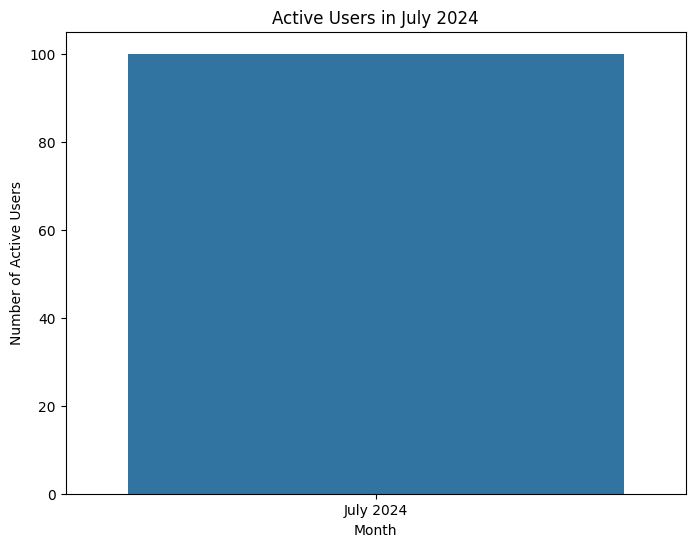

The number of active users in July 2024 is 100.

Here is a bar chart representing the active users in July 2024:

![Active Users in July 2024](sandbox:/mnt/data/active_users_july_chart.png)


In [24]:
output = app.invoke({"messages": [("human", "Count of active users in the month of July?")]})
print(output["messages"][-1].content)

**LangSmith Trace**: https://smith.langchain.com/o/d9fea088-bf32-40fb-9ea9-65a1bb5d6493/projects/p/328f5a9a-f37d-45a6-b5cb-e1939972e267?timeModel=%7B%22duration%22%3A%227d%22%7D

In [ ]:
# # Continue the conversation
# output = app.invoke(
#     {"messages": output["messages"] + [("human", "Which channel had the highest duration of viewing in last 200 days")]}
# )

# print(output["messages"][-1].content)